# 1. Import packages and Global parameters setting

In [1]:

from sklearn import datasets
iris = datasets.load_iris()

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

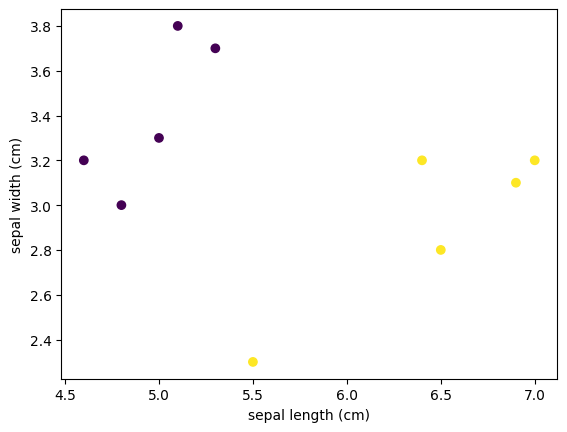

In [2]:
# remove virginica class
data_X = iris.data[iris.target != 2]
data_X = data_X[:, :2]  # only 2 features
# 1 if class is virginica, -1 if class is setosa
data_y = np.array([1 if i == 1 else -1 for i in iris.target[iris.target != 2]])

num_samples = 10
tot_samples = len(data_X)

data_X = data_X[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]
data_y = data_y[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]

_, ax = plt.subplots()
scatter = ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

In [3]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

g = [-data_y[i] * (w @ data_X[i] + b) + 1 <= 0.0 for i in range(data_y.shape[0])]

problem = cp.Problem(objective, g)

t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

time: 0.0444338321685791
2.040817385708519
Optimal w:  [ 1.4285752 -1.4285684]
Optimal b:  [-3.57146537]


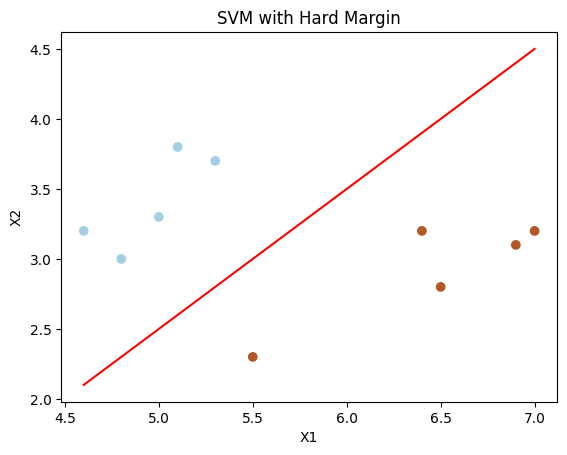

In [4]:
w_op = w.value
b_op = b.value

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_op[0] / w_op[1]) * x_plot - b_op / w_op[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# 2. The 5th NCP

In [5]:
nx = data_X.shape[1] + 1
nu = data_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:-1]
    b = x[-1]
    
    g = [-data_y[i] * (w @ data_X[i] + b) + 1 for i in range(data_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

In [6]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:3].set(1.0)

sol = solve_ivp(ODE, [0., 100.], xu0, t_eval=np.arange(0, 100, 0.01), method=NUMERICAL_METHOD)
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


2.0386846
[ 1.4444157  -1.41103958 -3.69912858  2.02945033  0.          0.
  0.          0.          0.          0.0000017   0.          2.03387218
  0.        ]


In [7]:
evalutation(result)

Array(2.0386846, dtype=float32)

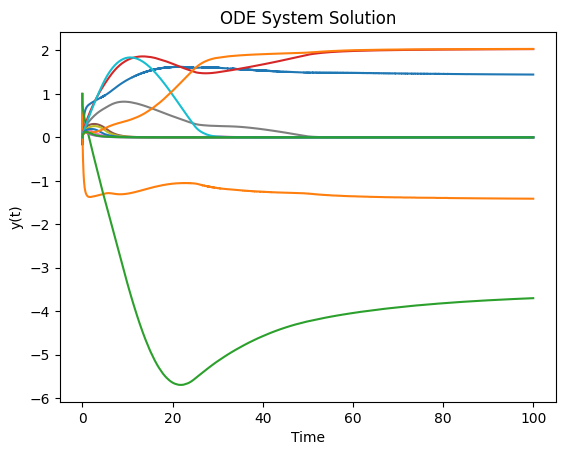

In [8]:
t_values = sol.t
y_values = sol.y

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

In [9]:
w_op = w.value
b_op = b.value

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

w_1_abs_diff = np.abs(w_op[0] - w_ode[0])
w_2_abs_diff = np.abs(w_op[1] - w_ode[1])
b_abs_diff = np.abs(b_op[0] - b_ode)

# Calculate the squared differences
w_1_sq_diff = w_1_abs_diff ** 2
w_2_sq_diff = w_2_abs_diff ** 2
b_sq_diff = b_abs_diff ** 2

mse_ = (w_1_sq_diff + w_2_sq_diff + b_sq_diff) / 3

print('w_1 absolute difference:', w_1_abs_diff)
print('w_2 absolute difference:', w_2_abs_diff)
print('b absolute difference:', b_abs_diff)

print('\nMSE between the two solutions:', mse_)

w_1 absolute difference: 0.015840503203394807
w_2 absolute difference: 0.01752881621645308
b absolute difference: 0.12766320889704952

MSE between the two solutions: 0.005618691948526217


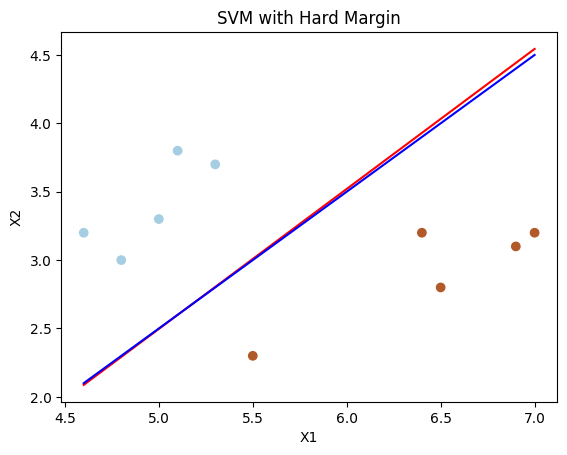

In [10]:
w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_ode[0] / w_ode[1]) * x_plot - b_ode / w_ode[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')


# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_op[0] / w_op[1]) * x_plot - b_op[0] / w_op[1]
plt.plot(x_plot, y_plot, color='b', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [11]:
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)


0.004421711 0.0008301657890972258


# 3. The method

In [20]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [21]:
y0 = np.zeros(NY)
y0[:3] = 1.0

In [22]:
NBATCH = 512 # 512
ITERATIONS = 1000

In [23]:
NEURONS = 500
LAYERS = 1
NN_weights = FNN(y0)
t_L = [np.random.uniform(0, 10, (NBATCH, 1)) for _ in range(ITERATIONS)]

In [24]:

LR = 0.0001
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method(weights=NN_weights, t_L=t_L) # train
res_L_1_0001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 15782.3340,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 100, Loss: 12217.1348,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 200, Loss: 7498.7158,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 300, Loss: 11831.6934,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 400, Loss: 11977.4531,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 500, Loss: 10168.4209,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   

In [25]:
LR = 0.001
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method(weights=NN_weights, t_L=t_L) # train
res_L_1_001 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 15782.3340,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 100, Loss: 6539.6250,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 200, Loss: 5625.0186,  epsilon_best: 21.3528, y_T: [ 3.6346 -5.4309 -2.1915  5.8837  5.0658  5.1435  5.1797  5.8543  0.9216
  1.362   0.8643  0.125   0.7216]
T: 100, Iteration: 300, Loss: 8583.0195,  epsilon_best: 21.3528, y_T: [ 3.6346 -5.4309 -2.1915  5.8837  5.0658  5.1435  5.1797  5.8543  0.9216
  1.362   0.8643  0.125   0.7216]
T: 100, Iteration: 400, Loss: 2220.7471,  epsilon_best: 21.3528, y_T: [ 3.6346 -5.4309 -2.1915  5.8837  5.0658  5.1435  5.1797  5.8543  0.9216
  1.362   0.8643  0.125   0.7216]
T: 100, Iteration: 500, Loss: 3036.2495,  epsilon_best: 21.3528, y_T: [ 3.6346 -5.4309 -2.1915  5.8837  5.0658  5.1435  5.17

In [26]:
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method(weights=NN_weights, t_L=t_L) # train
res_L_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 15782.3340,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 100, Loss: 2100.6311,  epsilon_best: 49.4316, y_T: [ 5.2398 -8.4503 -3.641   2.0395  0.8486  1.0052  1.0919  1.5298  4.016
  5.3389  3.6247  3.1704  3.2788]
T: 100, Iteration: 200, Loss: 12984.2139,  epsilon_best: 18.8842, y_T: [ 3.2196 -5.2347 -1.7761  1.2326  0.3792  0.8426  0.9102  0.9004  1.3239
  1.9754  1.4392  1.1546  1.1808]
T: 100, Iteration: 300, Loss: 9746.0195,  epsilon_best: 13.8922, y_T: [ 2.6437 -4.5602 -1.2792  1.4272  0.5032  0.7449  0.9615  1.0954  1.6543
  2.4869  1.705   1.1448  1.375 ]
T: 100, Iteration: 400, Loss: 6003.6309,  epsilon_best: 13.8922, y_T: [ 2.6437 -4.5602 -1.2792  1.4272  0.5032  0.7449  0.9615  1.0954  1.6543
  2.4869  1.705   1.1448  1.375 ]
T: 100, Iteration: 500, Loss: 4330.6475,  epsilon_best: 13.8922, y_T: [ 2.6437 -4.5602 -1.2792  1.4272  0.5032  0.7449  

In [28]:
LR = 0.1
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method(weights=NN_weights, t_L=t_L) # train
res_L_1_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 15782.3340,  epsilon_best: inf, y_T: [ 0.723   0.3861 -0.0252 -0.6684  0.4029  0.3625  1.1144  0.545   0.6646
 -0.2001  0.0505  0.6199  0.851 ]
T: 100, Iteration: 100, Loss: 3514.2957,  epsilon_best: 149.6440, y_T: [  8.9096 -14.8292  -7.5529  12.9408   9.9787  10.5491  11.2838  11.8297
   7.3119  12.7572   1.9715   1.0868   1.0762]
T: 100, Iteration: 200, Loss: 1760.6462,  epsilon_best: 61.8390, y_T: [ 6.3212 -9.1499 -5.063   8.7398  4.6575  5.8366  6.7102  7.7251  6.783
  8.6674  2.8435  0.0031  1.8172]
T: 100, Iteration: 300, Loss: 17766.9141,  epsilon_best: 26.2624, y_T: [ 3.96   -6.0699 -3.3309  6.1345  3.619   4.173   4.635   5.382   5.9232
  6.5748  2.2429  1.7163  2.1756]
T: 100, Iteration: 400, Loss: 1298.8923,  epsilon_best: 26.2624, y_T: [ 3.96   -6.0699 -3.3309  6.1345  3.619   4.173   4.635   5.382   5.9232
  6.5748  2.2429  1.7163  2.1756]
T: 100, Iteration: 500, Loss: 391.5743,  epsilon_best: 26.2624, y_T: [ 3.96   -6.0699 -3.3309  6.1345  3.6

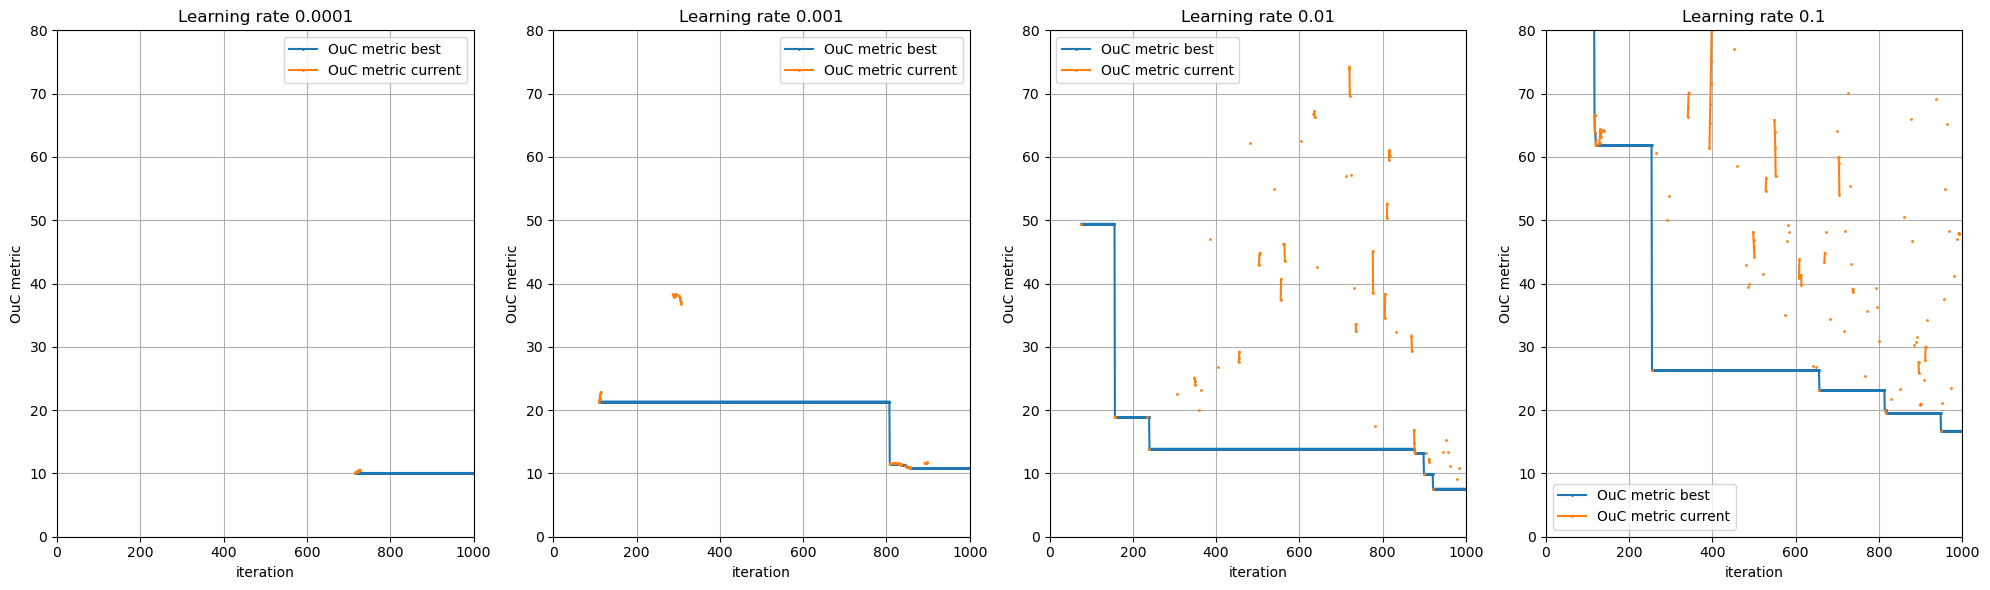

In [52]:
import matplotlib.pyplot as plt

# Assuming you have your dataframes res_L_1, res_L_2, res_L_3 ready

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 3 columns

# Find the overall minimum and maximum y-values across all dataframes, excluding infinities

# Filter out infinities for min calculation
y_min = min(np.min(np.array(res_L_1['L_epsilon'])[np.isfinite(res_L_1['L_epsilon'])]), 
            np.min(np.array(res_L_1['L_epsilon_curr'])[np.isfinite(res_L_1['L_epsilon_curr'])]),
            np.min(np.array(res_L_1_1['L_epsilon'])[np.isfinite(res_L_1_1['L_epsilon'])]), 
            np.min(np.array(res_L_1_1['L_epsilon_curr'])[np.isfinite(res_L_1_1['L_epsilon_curr'])]),
            np.min(np.array(res_L_1_001['L_epsilon'])[np.isfinite(res_L_1_001['L_epsilon'])]), 
            np.min(np.array(res_L_1_001['L_epsilon_curr'])[np.isfinite(res_L_1_001['L_epsilon_curr'])]),
            np.min(np.array(res_L_1_0001['L_epsilon'])[np.isfinite(res_L_1_0001['L_epsilon'])]), 
            np.min(np.array(res_L_1_0001['L_epsilon_curr'])[np.isfinite(res_L_1_0001['L_epsilon_curr'])]))

# Filter out infinities for max calculation
y_max = max(np.max(np.array(res_L_1['L_epsilon'])[np.isfinite(res_L_1['L_epsilon'])]), 
            np.max(np.array(res_L_1['L_epsilon_curr'])[np.isfinite(res_L_1['L_epsilon_curr'])]),
            np.max(np.array(res_L_1_1['L_epsilon'])[np.isfinite(res_L_1_1['L_epsilon'])]), 
            np.max(np.array(res_L_1_1['L_epsilon_curr'])[np.isfinite(res_L_1_1['L_epsilon_curr'])]),
            np.max(np.array(res_L_1_001['L_epsilon'])[np.isfinite(res_L_1_001['L_epsilon'])]), 
            np.max(np.array(res_L_1_001['L_epsilon_curr'])[np.isfinite(res_L_1_001['L_epsilon_curr'])]),
            np.max(np.array(res_L_1_0001['L_epsilon'])[np.isfinite(res_L_1_0001['L_epsilon'])]), 
            np.max(np.array(res_L_1_0001['L_epsilon_curr'])[np.isfinite(res_L_1_0001['L_epsilon_curr'])]))
y_min = 0
y_max = 80



# Plot on the first subplot
axes[0].plot(res_L_1_0001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[0].plot(res_L_1_0001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title('Learning rate 0.0001')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlim(0, 1000)

# Plot on the second subplot (assuming similar structure for res_L_2)
axes[1].plot(res_L_1_001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[1].plot(res_L_1_001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title('Learning rate 0.001')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[2].plot(res_L_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[2].plot(res_L_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title('Learning rate 0.01')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(y_min, y_max)
axes[2].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[3].plot(res_L_1_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[3].plot(res_L_1_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[3].set_xlabel('iteration')
axes[3].set_ylabel('OuC metric')
axes[3].set_title('Learning rate 0.1')
axes[3].legend()
axes[3].grid(True)
axes[3].set_ylim(y_min, y_max)
axes[3].set_xlim(0, 1000)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
LAYERS = 2
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_2 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1989.9275,  epsilon_best: inf, y_T: [ 1.2166  1.2909  0.7575 -0.2475  0.6185 -0.1823 -0.1225 -0.2072 -0.4156
  0.1705  0.4228 -0.1964  0.172 ]
T: 100, Iteration: 100, Loss: 221.5039,  epsilon_best: 47.9629, y_T: [ 4.9092 -8.475  -3.0116  1.9679  1.183   1.0607  1.3628  1.607   4.1017
  4.7855  3.6735  3.3667  3.2253]
T: 100, Iteration: 200, Loss: 1462.7983,  epsilon_best: 47.9629, y_T: [ 4.9092 -8.475  -3.0116  1.9679  1.183   1.0607  1.3628  1.607   4.1017
  4.7855  3.6735  3.3667  3.2253]
T: 100, Iteration: 300, Loss: 422.3752,  epsilon_best: 47.9629, y_T: [ 4.9092 -8.475  -3.0116  1.9679  1.183   1.0607  1.3628  1.607   4.1017
  4.7855  3.6735  3.3667  3.2253]
T: 100, Iteration: 400, Loss: 2081.6157,  epsilon_best: 44.7366, y_T: [ 5.22   -7.8882 -2.5961  2.423   1.1579  1.377   1.7486  2.0358  3.469
  4.2374  3.3423  3.0123  3.0522]
T: 100, Iteration: 500, Loss: 758.5651,  epsilon_best: 26.1509, y_T: [ 3.7286 -6.1967 -2.2154  1.8731  1.0803  1.2753  1.443

In [17]:
LAYERS = 3
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2688.4502,  epsilon_best: inf, y_T: [ 0.782   1.2768  0.918  -0.0192 -0.0909 -0.1284  0.2382 -0.0801 -0.0802
 -0.091   0.0262 -0.3182  0.1056]
T: 100, Iteration: 100, Loss: 575.3713,  epsilon_best: 16.1478, y_T: [ 2.9666 -4.8471 -1.7251  6.0287  5.357   5.5717  5.7601  5.7839  2.9253
  3.1696  2.8864  1.8437  2.5427]
T: 100, Iteration: 200, Loss: 335.1003,  epsilon_best: 16.1478, y_T: [ 2.9666 -4.8471 -1.7251  6.0287  5.357   5.5717  5.7601  5.7839  2.9253
  3.1696  2.8864  1.8437  2.5427]
T: 100, Iteration: 300, Loss: 170.6828,  epsilon_best: 16.1478, y_T: [ 2.9666 -4.8471 -1.7251  6.0287  5.357   5.5717  5.7601  5.7839  2.9253
  3.1696  2.8864  1.8437  2.5427]
T: 100, Iteration: 400, Loss: 215.0087,  epsilon_best: 16.1478, y_T: [ 2.9666 -4.8471 -1.7251  6.0287  5.357   5.5717  5.7601  5.7839  2.9253
  3.1696  2.8864  1.8437  2.5427]
T: 100, Iteration: 500, Loss: 824.7760,  epsilon_best: 16.1478, y_T: [ 2.9666 -4.8471 -1.7251  6.0287  5.357   5.5717  5.7601

In [18]:
LAYERS = 4
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_4 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1756.5092,  epsilon_best: inf, y_T: [ 1.0674  1.0149  0.928   0.019  -0.1821 -0.0437  0.0856 -0.0883 -0.0954
  0.0905 -0.0105 -0.011  -0.0138]
T: 100, Iteration: 100, Loss: 332.8166,  epsilon_best: 7.3496, y_T: [ 2.0552 -3.2366 -1.1732  5.092   4.9554  4.8544  5.2174  5.1855  3.0155
  3.235   2.9533  2.3797  2.6934]
T: 100, Iteration: 200, Loss: 2554.6411,  epsilon_best: 7.3496, y_T: [ 2.0552 -3.2366 -1.1732  5.092   4.9554  4.8544  5.2174  5.1855  3.0155
  3.235   2.9533  2.3797  2.6934]
T: 100, Iteration: 300, Loss: 6757.5459,  epsilon_best: 7.3496, y_T: [ 2.0552 -3.2366 -1.1732  5.092   4.9554  4.8544  5.2174  5.1855  3.0155
  3.235   2.9533  2.3797  2.6934]
T: 100, Iteration: 400, Loss: 220.9515,  epsilon_best: 7.3496, y_T: [ 2.0552 -3.2366 -1.1732  5.092   4.9554  4.8544  5.2174  5.1855  3.0155
  3.235   2.9533  2.3797  2.6934]
T: 100, Iteration: 500, Loss: 1255.5714,  epsilon_best: 7.3496, y_T: [ 2.0552 -3.2366 -1.1732  5.092   4.9554  4.8544  5.2174  

In [19]:
NEURONS = 100
LAYERS = 1
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1291.8290,  epsilon_best: inf, y_T: [ 1.3029  0.7906  1.6503  0.0541 -0.7139 -0.0923 -0.6297  0.536   0.3121
 -0.3818  0.4779  0.2953  0.3201]
T: 100, Iteration: 100, Loss: 1352.5831,  epsilon_best: 16.3347, y_T: [ 2.956  -4.892  -1.5194  3.931   2.5529  2.8994  3.1111  3.6472  0.871
  1.1792  0.9359  0.5626  0.6597]
T: 100, Iteration: 200, Loss: 388.9786,  epsilon_best: 16.3347, y_T: [ 2.956  -4.892  -1.5194  3.931   2.5529  2.8994  3.1111  3.6472  0.871
  1.1792  0.9359  0.5626  0.6597]
T: 100, Iteration: 300, Loss: 4157.8770,  epsilon_best: 16.3347, y_T: [ 2.956  -4.892  -1.5194  3.931   2.5529  2.8994  3.1111  3.6472  0.871
  1.1792  0.9359  0.5626  0.6597]
T: 100, Iteration: 400, Loss: 539.8491,  epsilon_best: 16.3347, y_T: [ 2.956  -4.892  -1.5194  3.931   2.5529  2.8994  3.1111  3.6472  0.871
  1.1792  0.9359  0.5626  0.6597]
T: 100, Iteration: 500, Loss: 57.8885,  epsilon_best: 15.7707, y_T: [ 2.8785 -4.8224 -1.5728  1.77    0.7921  1.1733  1.1383  1

In [20]:
NEURONS = 300
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 909.7379,  epsilon_best: inf, y_T: [-0.1445  0.3129  1.7581  0.4747  0.5146  0.871  -0.2326  0.5107 -0.1931
 -0.3449  0.3927  0.4833  0.8295]
T: 100, Iteration: 100, Loss: 1239.5343,  epsilon_best: 25.9643, y_T: [ 3.8988 -6.0603 -2.1501  9.036   8.6814  8.6738  8.8725  9.226   1.2308
  1.0564  1.9212  0.3041  1.1362]
T: 100, Iteration: 200, Loss: 737.3346,  epsilon_best: 24.0234, y_T: [ 3.7035 -5.8592 -3.2375  4.5475  2.7101  3.3097  3.413   4.0316  1.8499
  2.4066  1.3294  1.0878  1.0625]
T: 100, Iteration: 300, Loss: 207.0135,  epsilon_best: 24.0234, y_T: [ 3.7035 -5.8592 -3.2375  4.5475  2.7101  3.3097  3.413   4.0316  1.8499
  2.4066  1.3294  1.0878  1.0625]
T: 100, Iteration: 400, Loss: 261.9144,  epsilon_best: 24.0234, y_T: [ 3.7035 -5.8592 -3.2375  4.5475  2.7101  3.3097  3.413   4.0316  1.8499
  2.4066  1.3294  1.0878  1.0625]
T: 100, Iteration: 500, Loss: 220.3371,  epsilon_best: 24.0234, y_T: [ 3.7035 -5.8592 -3.2375  4.5475  2.7101  3.3097  3.413 

In [21]:
NEURONS = 500
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_5 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2115.5544,  epsilon_best: inf, y_T: [ 1.6487  1.4988  0.7479 -0.5027 -0.8773  0.5953  0.2601 -0.335  -0.3498
 -0.1282  0.4557 -0.0279 -0.0126]
T: 100, Iteration: 100, Loss: 94.3139,  epsilon_best: 48.9739, y_T: [ 5.4937 -8.2321 -3.6027 11.4228  9.9165 10.9709 11.1219 11.3369  1.3014
  0.7714  2.0432 -0.4543  0.8391]
T: 100, Iteration: 200, Loss: 6524.4248,  epsilon_best: 48.9739, y_T: [ 5.4937 -8.2321 -3.6027 11.4228  9.9165 10.9709 11.1219 11.3369  1.3014
  0.7714  2.0432 -0.4543  0.8391]
T: 100, Iteration: 300, Loss: 1954.2609,  epsilon_best: 48.9739, y_T: [ 5.4937 -8.2321 -3.6027 11.4228  9.9165 10.9709 11.1219 11.3369  1.3014
  0.7714  2.0432 -0.4543  0.8391]
T: 100, Iteration: 400, Loss: 131.1099,  epsilon_best: 28.9141, y_T: [ 3.8753 -6.5429 -2.2513  3.4011  1.471   1.7428  2.0707  2.8454  1.4125
  1.5825  1.443   0.9637  1.1544]
T: 100, Iteration: 500, Loss: 680.0256,  epsilon_best: 21.5626, y_T: [ 3.4261 -5.6024 -1.2493  2.0333  1.3711  1.2365  1.790

In [22]:
NEURONS = 700
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_7 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2443.1504,  epsilon_best: inf, y_T: [ 1.3598  0.3437  1.5369 -0.6348  0.9158  0.0503 -0.2902  0.4133 -1.0844
 -0.345  -0.3428  0.1728  0.1295]
T: 100, Iteration: 100, Loss: 3230.5269,  epsilon_best: 35.3439, y_T: [ 4.3549 -7.1918 -3.66    3.2106  2.8243  2.7511  2.5926  2.2355  2.9045
  3.1087  3.013   2.2722  2.3512]
T: 100, Iteration: 200, Loss: 321.7610,  epsilon_best: 30.6415, y_T: [ 4.3039 -6.539  -3.6394  3.8895  2.4581  2.7515  2.99    3.5629  1.4074
  2.5737  1.0463  0.226   0.7669]
T: 100, Iteration: 300, Loss: 3360.1992,  epsilon_best: 27.3318, y_T: [ 3.8913 -6.2866 -3.3738  4.5108  3.573   4.0824  4.1004  4.3944  3.0055
  3.4718  2.5788  1.1844  1.87  ]
T: 100, Iteration: 400, Loss: 10402.5283,  epsilon_best: 24.4917, y_T: [ 3.7532 -5.9073 -2.3447  5.5686  3.7264  3.9472  4.1789  4.9528  2.1019
  1.6108  1.9605  0.1431  1.101 ]
T: 100, Iteration: 500, Loss: 30.8861,  epsilon_best: 16.0048, y_T: [ 3.042  -4.7703 -2.2091  2.8651  1.8142  2.0787  2.3

In [23]:
NEURONS = 900
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_9 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 3114.8442,  epsilon_best: inf, y_T: [ 1.3636  1.7918  1.6012 -0.0716 -0.7131  0.4655  0.498  -0.4745  0.2454
 -0.2927 -0.118  -0.0854 -0.3162]
T: 100, Iteration: 100, Loss: 963.4773,  epsilon_best: 156.4925, y_T: [  9.2184 -15.0999  -6.0128  14.9975  12.8483  13.4181  14.3152  14.4805
   5.3037  -0.168    2.6904   4.4111   3.1977]
T: 100, Iteration: 200, Loss: 1442.7739,  epsilon_best: 48.1008, y_T: [ 5.462  -8.1467 -4.8854  4.4455  2.9857  2.9167  2.9872  3.5203  2.477
  4.5732  2.2291  1.2885  1.8083]
T: 100, Iteration: 300, Loss: 379.2430,  epsilon_best: 48.1008, y_T: [ 5.462  -8.1467 -4.8854  4.4455  2.9857  2.9167  2.9872  3.5203  2.477
  4.5732  2.2291  1.2885  1.8083]
T: 100, Iteration: 400, Loss: 291.0838,  epsilon_best: 48.1008, y_T: [ 5.462  -8.1467 -4.8854  4.4455  2.9857  2.9167  2.9872  3.5203  2.477
  4.5732  2.2291  1.2885  1.8083]
T: 100, Iteration: 500, Loss: 2511.2681,  epsilon_best: 48.1008, y_T: [ 5.462  -8.1467 -4.8854  4.4455  2.9857  2

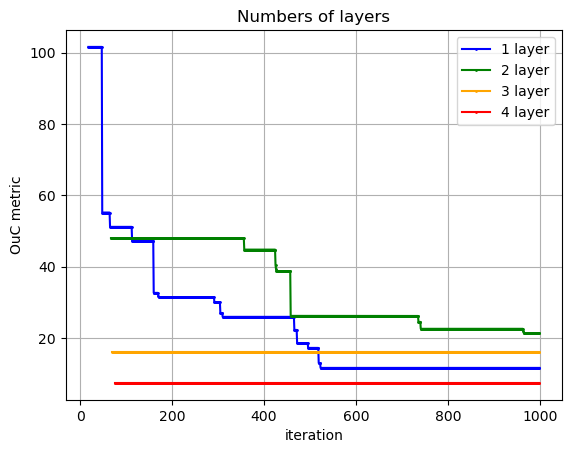

In [24]:
# Plot each dataset with labels
plt.plot(res_L_1['L_epsilon'], marker='o', linestyle='-', color='blue', label='1 layer', markersize=1)
plt.plot(res_L_2['L_epsilon'], marker='o', linestyle='-', color='green', label='2 layer', markersize=1)
plt.plot(res_L_3['L_epsilon'], marker='o', linestyle='-', color='orange', label='3 layer', markersize=1)
plt.plot(res_L_4['L_epsilon'], marker='o', linestyle='-', color='red', label='4 layer', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()


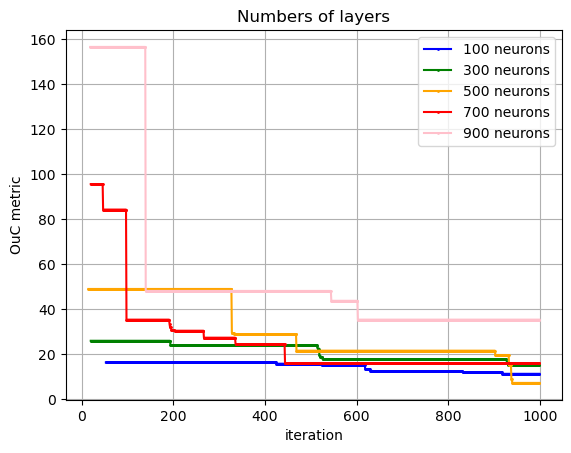

In [25]:
# Plot each dataset with labels
plt.plot(res_N_1['L_epsilon'], marker='o', linestyle='-', color='blue', label='100 neurons', markersize=1)
plt.plot(res_N_3['L_epsilon'], marker='o', linestyle='-', color='green', label='300 neurons', markersize=1)
plt.plot(res_N_5['L_epsilon'], marker='o', linestyle='-', color='orange', label='500 neurons', markersize=1)
plt.plot(res_N_7['L_epsilon'], marker='o', linestyle='-', color='red', label='700 neurons', markersize=1)
plt.plot(res_N_9['L_epsilon'], marker='o', linestyle='-', color='pink', label='900 neurons', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

In [39]:
NEURONS = 100
LAYERS = 4
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_1= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1508.1195,  epsilon_best: inf, y_T: [ 1.0469  1.0914  1.0126  0.1188 -0.2898 -0.1079 -0.1564 -0.0425 -0.161
 -0.0457 -0.0413 -0.0927 -0.1422]
T: 100, Iteration: 100, Loss: 553.2438,  epsilon_best: inf, y_T: [ 1.0469  1.0914  1.0126  0.1188 -0.2898 -0.1079 -0.1564 -0.0425 -0.161
 -0.0457 -0.0413 -0.0927 -0.1422]
T: 100, Iteration: 200, Loss: 248.7041,  epsilon_best: inf, y_T: [ 1.0469  1.0914  1.0126  0.1188 -0.2898 -0.1079 -0.1564 -0.0425 -0.161
 -0.0457 -0.0413 -0.0927 -0.1422]
T: 100, Iteration: 300, Loss: 240.3710,  epsilon_best: 8.2101, y_T: [ 2.0843 -3.475  -0.8829  1.3001  1.1134  1.0452  1.2802  1.2777  2.2565
  2.4627  2.1947  1.9403  2.0586]
T: 100, Iteration: 400, Loss: 41.6972,  epsilon_best: 8.2101, y_T: [ 2.0843 -3.475  -0.8829  1.3001  1.1134  1.0452  1.2802  1.2777  2.2565
  2.4627  2.1947  1.9403  2.0586]
T: 100, Iteration: 500, Loss: 159.9363,  epsilon_best: 8.2101, y_T: [ 2.0843 -3.475  -0.8829  1.3001  1.1134  1.0452  1.2802  1.2777  2.256

In [40]:
NEURONS = 300
LAYERS = 4
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_3= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 960.9662,  epsilon_best: inf, y_T: [ 0.94    0.8437  0.8057 -0.0496 -0.2059  0.0877 -0.0284 -0.1325 -0.1625
 -0.0484  0.0137  0.036   0.0601]
T: 100, Iteration: 100, Loss: 664.9554,  epsilon_best: inf, y_T: [ 0.94    0.8437  0.8057 -0.0496 -0.2059  0.0877 -0.0284 -0.1325 -0.1625
 -0.0484  0.0137  0.036   0.0601]
T: 100, Iteration: 200, Loss: 4513.7646,  epsilon_best: 9.3857, y_T: [ 2.218  -3.7218 -1.1042  2.0249  1.686   1.6602  1.9075  1.9381  2.4958
  2.8576  2.4839  2.1984  2.2658]
T: 100, Iteration: 300, Loss: 48.9604,  epsilon_best: 9.3857, y_T: [ 2.218  -3.7218 -1.1042  2.0249  1.686   1.6602  1.9075  1.9381  2.4958
  2.8576  2.4839  2.1984  2.2658]
T: 100, Iteration: 400, Loss: 372.6620,  epsilon_best: 9.3857, y_T: [ 2.218  -3.7218 -1.1042  2.0249  1.686   1.6602  1.9075  1.9381  2.4958
  2.8576  2.4839  2.1984  2.2658]
T: 100, Iteration: 500, Loss: 780.8959,  epsilon_best: 9.3857, y_T: [ 2.218  -3.7218 -1.1042  2.0249  1.686   1.6602  1.9075  1.9381 

In [41]:
NEURONS = 500
LAYERS = 4
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_5= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 944.7792,  epsilon_best: inf, y_T: [ 0.9686  0.9407  1.1019 -0.0407 -0.1239  0.1384  0.044  -0.0267 -0.0439
  0.0426 -0.0184  0.0211 -0.0831]
T: 100, Iteration: 100, Loss: 1175.4946,  epsilon_best: 7.2737, y_T: [ 1.9975 -3.2492 -0.8449  3.3873  3.1396  3.1226  3.2839  3.2824  2.9438
  3.1638  2.8441  2.294   2.628 ]
T: 100, Iteration: 200, Loss: 1774.5803,  epsilon_best: 7.2737, y_T: [ 1.9975 -3.2492 -0.8449  3.3873  3.1396  3.1226  3.2839  3.2824  2.9438
  3.1638  2.8441  2.294   2.628 ]
T: 100, Iteration: 300, Loss: 146.3785,  epsilon_best: 7.2737, y_T: [ 1.9975 -3.2492 -0.8449  3.3873  3.1396  3.1226  3.2839  3.2824  2.9438
  3.1638  2.8441  2.294   2.628 ]
T: 100, Iteration: 400, Loss: 81.7394,  epsilon_best: 7.2737, y_T: [ 1.9975 -3.2492 -0.8449  3.3873  3.1396  3.1226  3.2839  3.2824  2.9438
  3.1638  2.8441  2.294   2.628 ]
T: 100, Iteration: 500, Loss: 1954.0950,  epsilon_best: 7.2737, y_T: [ 1.9975 -3.2492 -0.8449  3.3873  3.1396  3.1226  3.2839  3.

In [42]:
NEURONS = 100
LAYERS = 3
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_3_1= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1931.3201,  epsilon_best: inf, y_T: [ 1.0856  0.8391  0.9157 -0.1898  0.0869  0.0201  0.2688 -0.0033  0.0999
 -0.1773 -0.3818  0.0448  0.034 ]
T: 100, Iteration: 100, Loss: 411.5533,  epsilon_best: inf, y_T: [ 1.0856  0.8391  0.9157 -0.1898  0.0869  0.0201  0.2688 -0.0033  0.0999
 -0.1773 -0.3818  0.0448  0.034 ]
T: 100, Iteration: 200, Loss: 229.8553,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.5326  1.3727
  1.6647  1.2809  1.1257  1.2134]
T: 100, Iteration: 300, Loss: 1204.3853,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.5326  1.3727
  1.6647  1.2809  1.1257  1.2134]
T: 100, Iteration: 400, Loss: 209.6014,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.5326  1.3727
  1.6647  1.2809  1.1257  1.2134]
T: 100, Iteration: 500, Loss: 1168.4613,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.53

T: 100, Iteration: 800, Loss: 70.0466,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.5326  1.3727
  1.6647  1.2809  1.1257  1.2134]
T: 100, Iteration: 900, Loss: 1145.2041,  epsilon_best: 7.9933, y_T: [ 2.063  -3.425  -0.9652  1.6156  1.1533  1.2747  1.3261  1.5326  1.3727
  1.6647  1.2809  1.1257  1.2134]


In [43]:
NEURONS = 300
LAYERS = 3
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_3_3= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1813.0189,  epsilon_best: inf, y_T: [ 1.1282  0.9877  1.4458  0.0965  0.0106  0.0808  0.0344  0.0389  0.103
 -0.0964  0.1479  0.108   0.1819]
T: 100, Iteration: 100, Loss: 442.1355,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]
T: 100, Iteration: 200, Loss: 383.7763,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]
T: 100, Iteration: 300, Loss: 66.6294,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]
T: 100, Iteration: 400, Loss: 81.6784,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]
T: 100, Iteration: 500, Loss: 135.2707,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523

T: 100, Iteration: 800, Loss: 851.6034,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]
T: 100, Iteration: 900, Loss: 75.3315,  epsilon_best: 7.8156, y_T: [ 2.0214 -3.3978 -0.9207  3.6635  3.2697  3.282   3.4339  3.5523  2.0298
  2.1553  1.882   1.4813  1.805 ]


In [44]:
NEURONS = 500
LAYERS = 3
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_3_5= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1759.3794,  epsilon_best: inf, y_T: [ 1.0913  0.9583  1.0435 -0.0201  0.0318 -0.1439 -0.0758 -0.3588 -0.1788
 -0.1382 -0.3077 -0.0983  0.1835]
T: 100, Iteration: 100, Loss: 501.7331,  epsilon_best: 31.4050, y_T: [ 4.2823 -6.6687 -1.9811  2.3941  1.5547  1.649   1.9796  2.1288  3.0343
  3.8161  2.9053  2.2435  2.5471]
T: 100, Iteration: 200, Loss: 3018.8975,  epsilon_best: 31.4050, y_T: [ 4.2823 -6.6687 -1.9811  2.3941  1.5547  1.649   1.9796  2.1288  3.0343
  3.8161  2.9053  2.2435  2.5471]
T: 100, Iteration: 300, Loss: 796.1719,  epsilon_best: 31.4050, y_T: [ 4.2823 -6.6687 -1.9811  2.3941  1.5547  1.649   1.9796  2.1288  3.0343
  3.8161  2.9053  2.2435  2.5471]
T: 100, Iteration: 400, Loss: 974.0544,  epsilon_best: 31.4050, y_T: [ 4.2823 -6.6687 -1.9811  2.3941  1.5547  1.649   1.9796  2.1288  3.0343
  3.8161  2.9053  2.2435  2.5471]
T: 100, Iteration: 500, Loss: 141.3829,  epsilon_best: 29.6658, y_T: [ 3.9051 -6.6394 -2.268   2.0763  0.905   1.0651  1.278

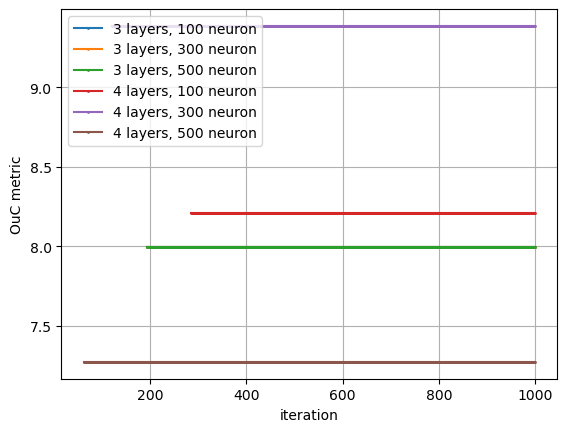

In [49]:
# Plot each dataset with labels
plt.plot(res_3_1['L_epsilon'], marker='o', linestyle='-', label='3 layers, 100 neuron', markersize=1)
plt.plot(res_3_1['L_epsilon'], marker='o', linestyle='-', label='3 layers, 300 neuron', markersize=1)
plt.plot(res_3_1['L_epsilon'], marker='o', linestyle='-', label='3 layers, 500 neuron', markersize=1)
plt.plot(res_4_1['L_epsilon'], marker='o', linestyle='-', label='4 layers, 100 neuron', markersize=1)
plt.plot(res_4_3['L_epsilon'], marker='o', linestyle='-', label='4 layers, 300 neuron', markersize=1)
plt.plot(res_4_5['L_epsilon'], marker='o', linestyle='-', label='4 layers, 500 neuron', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

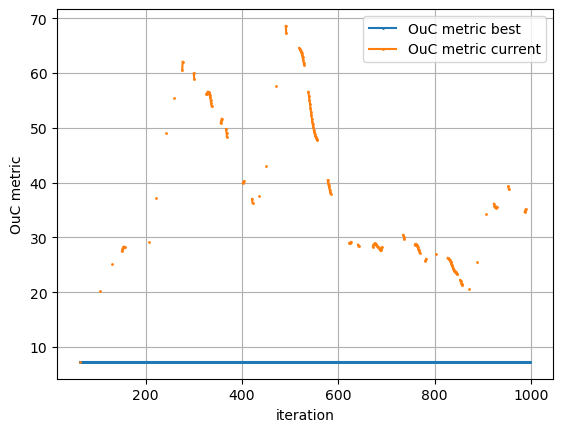

In [52]:
# Plot each dataset with labels
plt.plot(res_4_5['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res_4_5['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)


# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

In [45]:
NEURONS = 500
LAYERS = 4
NN_weights = FNN(y0)
t_L = [np.random.uniform(0, 10, (NBATCH, 1)) for _ in range(ITERATIONS)]

LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_5= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1712.0725,  epsilon_best: inf, y_T: [ 0.9602  1.0878  1.1854 -0.1123 -0.0394 -0.0333 -0.0046 -0.0562 -0.1336
 -0.0048 -0.0485  0.2096  0.2254]
T: 100, Iteration: 100, Loss: 265.3168,  epsilon_best: 10.9644, y_T: [ 2.3928 -4.0253 -1.0876  1.9503  1.365   1.4078  1.6084  1.7433  2.2325
  2.5087  2.093   1.7936  1.9377]
T: 100, Iteration: 200, Loss: 664.7985,  epsilon_best: 10.9644, y_T: [ 2.3928 -4.0253 -1.0876  1.9503  1.365   1.4078  1.6084  1.7433  2.2325
  2.5087  2.093   1.7936  1.9377]
T: 100, Iteration: 300, Loss: 2052.5581,  epsilon_best: 10.9644, y_T: [ 2.3928 -4.0253 -1.0876  1.9503  1.365   1.4078  1.6084  1.7433  2.2325
  2.5087  2.093   1.7936  1.9377]
T: 100, Iteration: 400, Loss: 656.4868,  epsilon_best: 10.9644, y_T: [ 2.3928 -4.0253 -1.0876  1.9503  1.365   1.4078  1.6084  1.7433  2.2325
  2.5087  2.093   1.7936  1.9377]
T: 100, Iteration: 500, Loss: 897.9400,  epsilon_best: 10.9644, y_T: [ 2.3928 -4.0253 -1.0876  1.9503  1.365   1.4078  1.608

In [46]:
LR = 0.001
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_5_001= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1701.2549,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -0.1037 -0.1369 -0.0335 -0.0968]
T: 100, Iteration: 100, Loss: 716.6379,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -0.1037 -0.1369 -0.0335 -0.0968]
T: 100, Iteration: 200, Loss: 863.1740,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -0.1037 -0.1369 -0.0335 -0.0968]
T: 100, Iteration: 300, Loss: 250.8319,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -0.1037 -0.1369 -0.0335 -0.0968]
T: 100, Iteration: 400, Loss: 659.0121,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -0.1037 -0.1369 -0.0335 -0.0968]
T: 100, Iteration: 500, Loss: 1007.9395,  epsilon_best: inf, y_T: [ 1.0171  1.0438  1.0421 -0.0695  0.1191  0.032   0.0298  0.0117  0.1464
 -

In [47]:
LR = 0.0001
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_5_0001= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2585.4309,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556
  0.0721  0.0252  0.0224  0.126 ]
T: 100, Iteration: 100, Loss: 1280.4255,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556
  0.0721  0.0252  0.0224  0.126 ]
T: 100, Iteration: 200, Loss: 1465.5815,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556
  0.0721  0.0252  0.0224  0.126 ]
T: 100, Iteration: 300, Loss: 499.3036,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556
  0.0721  0.0252  0.0224  0.126 ]
T: 100, Iteration: 400, Loss: 668.4369,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556
  0.0721  0.0252  0.0224  0.126 ]
T: 100, Iteration: 500, Loss: 1016.9390,  epsilon_best: inf, y_T: [ 0.9961  0.9726  1.0123  0.0444  0.0267  0.1483 -0.1035  0.123   0.0556


In [48]:
LR = 0.1
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_4_5_1= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2272.9429,  epsilon_best: inf, y_T: [ 1.0799  1.0638  0.9305  0.0703 -0.087   0.1668 -0.0214  0.069  -0.0197
  0.0959 -0.0408  0.0944 -0.0535]
T: 100, Iteration: 100, Loss: 474.0181,  epsilon_best: 103.9904, y_T: [  8.0058 -11.9953  -3.5208   4.029    4.1577   3.7037   4.5078   4.2416
   5.5399   6.0715   5.3943   4.6109   4.9395]
T: 100, Iteration: 200, Loss: 393.6173,  epsilon_best: 40.2623, y_T: [ 4.6742 -7.6601 -0.6211  0.5837  0.4276  0.4162  0.5117  0.5404  1.1732
  1.7137  1.1203  1.0186  1.0338]
T: 100, Iteration: 300, Loss: 68.0555,  epsilon_best: 25.1773, y_T: [ 3.7132 -6.047  -0.7699  1.1994  0.5877  0.6554  0.7651  0.9252  1.1385
  1.0877  1.1971  1.3135  1.251 ]
T: 100, Iteration: 400, Loss: 133.3222,  epsilon_best: 25.1773, y_T: [ 3.7132 -6.047  -0.7699  1.1994  0.5877  0.6554  0.7651  0.9252  1.1385
  1.0877  1.1971  1.3135  1.251 ]
T: 100, Iteration: 500, Loss: 15.2472,  epsilon_best: 22.6315, y_T: [ 3.3754 -5.8198 -0.6768 -0.2485 -0.028  -0.

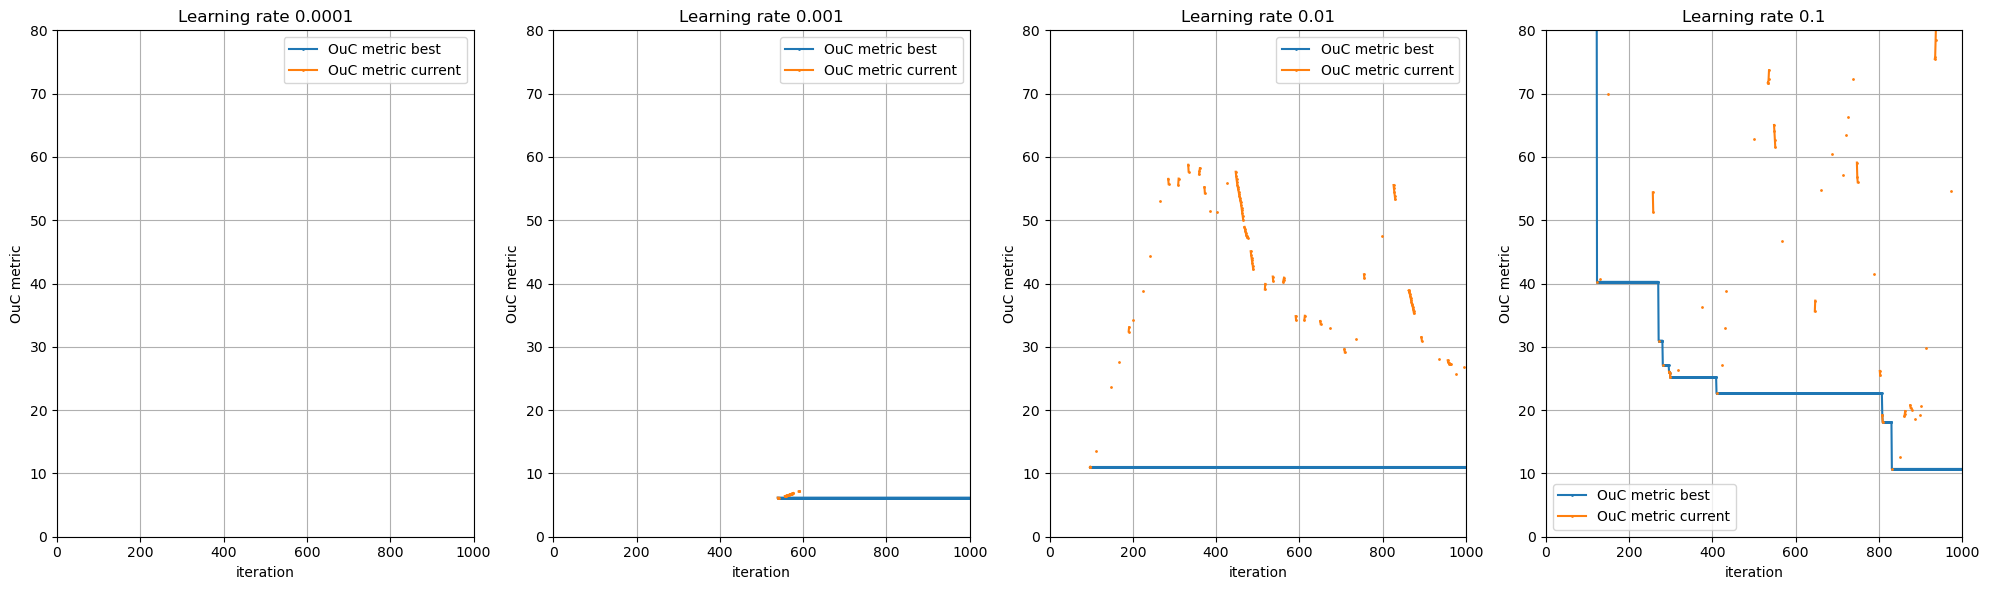

In [51]:
import matplotlib.pyplot as plt

# Assuming you have your dataframes res_L_1, res_L_2, res_L_3 ready

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 3 columns

y_min = 0
y_max = 80



# Plot on the first subplot
axes[0].plot(res_4_5_0001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[0].plot(res_4_5_0001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title('Learning rate 0.0001')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlim(0, 1000)

# Plot on the second subplot (assuming similar structure for res_L_2)
axes[1].plot(res_4_5_001['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[1].plot(res_4_5_001['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title('Learning rate 0.001')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[2].plot(res_4_5['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[2].plot(res_4_5['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title('Learning rate 0.01')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(y_min, y_max)
axes[2].set_xlim(0, 1000)

# Plot on the third subplot (assuming similar structure for res_L_3)
axes[3].plot(res_4_5_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
axes[3].plot(res_4_5_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
axes[3].set_xlabel('iteration')
axes[3].set_ylabel('OuC metric')
axes[3].set_title('Learning rate 0.1')
axes[3].legend()
axes[3].grid(True)
axes[3].set_ylim(y_min, y_max)
axes[3].set_xlim(0, 1000)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
res_4_5['L_y_T'][-1]

array([ 1.99753  , -3.2491965, -0.8448781,  3.3873134,  3.1396203,
        3.12262  ,  3.2839386,  3.2823899,  2.943812 ,  3.1638362,
        2.8440552,  2.2939723,  2.6279964], dtype=float32)

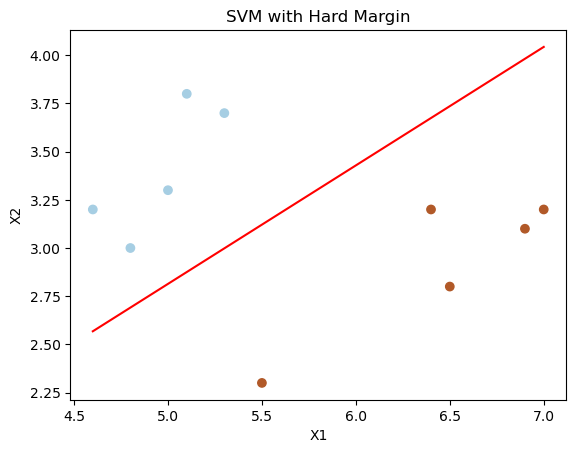

In [47]:
w_pinn = res_4_5['L_y_T'][-1][:data_X.shape[1]]
b_pinn = res_4_5['L_y_T'][-1][data_X.shape[1]]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_pinn[0] / w_pinn[1]) * x_plot - b_pinn / w_pinn[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [48]:
w_1_abs_diff = np.abs(w_op[0] - w_pinn[0])
w_2_abs_diff = np.abs(w_op[1] - w_pinn[1])
b_abs_diff = np.abs(b_op[0] - b_pinn)

# Calculate the squared differences
w_1_sq_diff = w_1_abs_diff ** 2
w_2_sq_diff = w_2_abs_diff ** 2
b_sq_diff = b_abs_diff ** 2

mse_ = (w_1_sq_diff + w_2_sq_diff + b_sq_diff) / 3

print('w_1 absolute difference:', w_1_abs_diff)
print('w_2 absolute difference:', w_2_abs_diff)
print('b absolute difference:', b_abs_diff)

print('\nMSE between the two solutions:', mse_)

w_1 absolute difference: 0.5689547822450585
w_2 absolute difference: 1.820628132104682
b absolute difference: 2.726587297221755

MSE between the two solutions: 3.6908915430071807


In [73]:
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
sol = solve_ivp(ODE, t_span, y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y

In [74]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

In [59]:
y_ODE.shape

(13, 1000)

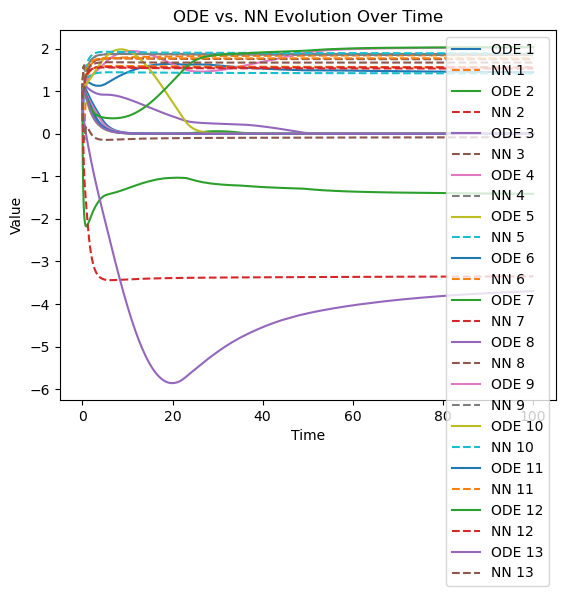

In [20]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()